In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import sys
import keras
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file, plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
print(pd.__version__)
print(np.__version__)
print(sys.version)
print(sklearn.__version__)

1.3.5
1.21.6
3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
1.0.2


In [ ]:
#Loading training set into dataframe
df = pd.read_csv('UNSW_NB15_testing-set.csv')
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [ ]:
#Loading testing set into dataframe
qp = pd.read_csv('UNSW_NB15_training-set.csv')
qp

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,...,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,...,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,...,1,1,0,0,0,1,1,1,Normal,0


In [ ]:
#Dropping the last columns of training set
df = df.drop('id', 1) # we don't need it in this project
df.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


(175341, 44)

In [ ]:
df = df.drop('label', 1) # we don't need it in this project
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal


In [ ]:
#Dropping the last columns of testing set
qp = qp.drop('id', 1)
qp = qp.drop('label', 1)
qp.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


(82332, 43)

In [ ]:
df.isnull().values.any()

False

In [ ]:
qp.isnull().values.any()

False

In [ ]:
#defining col list
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [ ]:
#One-hot encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df

In [ ]:
#Merging train and test data
combined_data = pd.concat([df,qp])
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,Normal
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,Normal
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal


In [ ]:
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,Normal
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,Normal
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal


In [ ]:
tmp = combined_data.pop('attack_cat')

In [ ]:
#Applying one hot encoding to combined data
combined_data = one_hot(combined_data,cols)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
combined_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,0,0,0,0,0,0,0,0,0,0
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,...,0,0,0,0,0,0,0,0,0,0
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,...,0,0,0,0,0,0,0,0,0,0
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,...,1,0,0,0,0,0,0,0,0,0
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,...,0,0,0,0,0,0,0,0,0,0
82328,1.106101,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,...,0,0,0,0,0,0,0,0,0,0
82329,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0
82330,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
#Normalizing training set
new_train_df = normalize(combined_data,combined_data.columns)
new_train_df

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tmp

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
82327    Normal
82328    Normal
82329    Normal
82330    Normal
82331    Normal
Name: attack_cat, Length: 257673, dtype: object

In [ ]:
#Appending class column to training set
new_train_df["Class"] = tmp
new_train_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,Class
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal


In [ ]:
new_train_df.isnull().values.any()

False

In [ ]:
y_train=new_train_df["Class"]
y_train

0        Normal
1        Normal
2        Normal
3        Normal
4        Normal
          ...  
82327    Normal
82328    Normal
82329    Normal
82330    Normal
82331    Normal
Name: Class, Length: 257673, dtype: object

In [ ]:
y_train.isnull().values.any()

False

In [ ]:
combined_data_X = new_train_df.drop('Class', 1)
combined_data_X

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,2.024634e-03,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.083170e-02,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.705215e-02,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.802737e-02,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.490901e-03,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,8.333335e-08,0.000094,0.000000,0.000006,0.000000,0.200000,0.996078,0.000000,1.389445e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82328,1.843502e-02,0.001785,0.000726,0.001257,0.000024,0.000024,0.996078,0.992126,2.072552e-05,0.000100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82329,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82330,0.000000e+00,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
oos_pred = []

#Oversampling

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')

In [ ]:
kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=42)
kfold.get_n_splits(combined_data_X,y_train)

3

In [ ]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=64, padding="same",activation="relu",input_shape=(196, 1)))
model.add(MaxPooling1D(pool_size=(10)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape = (128, )))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))
#model.add(Reshape((128, 1), input_shape = (128, )))
model.add(Dropout(0.6))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
for layer in model.layers:
    print(layer.output_shape)

(None, 196, 64)
(None, 19, 64)
(None, 19, 64)
(None, 128)
(None, 128, 1)
(None, 25, 1)
(None, 25, 1)
(None, 256)
(None, 256)
(None, 10)
(None, 10)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 196, 64)           4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 64)           0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 19, 64)           256       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                        

In [ ]:
for train_index, test_index in kfold.split(combined_data_X,y_train):
    train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]

    print("train index:",train_index)
    print("test index:",test_index)
    print(train_y.value_counts())

    train_X_over,train_y_over= oversample.fit_resample(train_X, train_y)
    print(train_y_over.value_counts())

    x_columns_train = new_train_df.columns.drop('Class')
    x_train_array = train_X_over[x_columns_train].values
    x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))

    dummies = pd.get_dummies(train_y_over) # Classification
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y_train_1 = dummies.values

    x_columns_test = new_train_df.columns.drop('Class')
    x_test_array = test_X[x_columns_test].values
    x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))

    dummies_test = pd.get_dummies(test_y) # Classification
    outcomes_test = dummies_test.columns
    num_classes = len(outcomes_test)
    y_test_2 = dummies_test.values


    model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=9)

    pred = model.predict(x_test_2)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test_2,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    oos_pred.append(score)
    print("Validation score: {}".format(score))

train index: [     1      2      4 ... 257667 257669 257670]
test index: [     0      3      7 ... 257668 257671 257672]
Normal            62000
Generic           39248
Exploits          29683
Fuzzers           16164
DoS               10902
Reconnaissance     9325
Analysis           1785
Backdoor           1552
Shellcode          1007
Worms               116
Name: Class, dtype: int64
Normal            62000
Worms             62000
Generic           39248
Exploits          29683
Fuzzers           16164
DoS               10902
Reconnaissance     9325
Analysis           1785
Backdoor           1552
Shellcode          1007
Name: Class, dtype: int64
Epoch 1/9
7303/7303 [==============================] - 602s 82ms/step - loss: 0.3692 - accuracy: 0.8546 - val_loss: 0.5027 - val_accuracy: 0.8030
Epoch 2/9
7303/7303 [==============================] - 605s 83ms/step - loss: 0.3661 - accuracy: 0.8558 - val_loss: 0.4901 - val_accuracy: 0.8070
Epoch 3/9
7303/7303 [==============================] - 

KeyboardInterrupt: ignored

In [ ]:
oos_pred

[0.808131141433428,
 0.8125087318958693,
 0.8186559865878079,
 0.8198626149726395,
 0.8220514611712656,
 0.823285597857725]

In [ ]:
test_y.value_counts()

Normal            15500
Generic            9812
Exploits           7421
Fuzzers            4041
DoS                2725
Reconnaissance     2331
Analysis            446
Backdoor            388
Shellcode           252
Worms                29
Name: Class, dtype: int64

In [ ]:
dummies_test.columns

Index(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
      dtype='object')

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confussion_matrix=confusion_matrix(y_eval, pred, labels=[0, 1, 2, 3, 4, 5,6, 7, 8, 9])

In [ ]:
confussion_matrix

array([[   28,     0,     6,   357,     4,     0,    51,     0,     0,
            0],
       [    0,    29,    14,   335,     2,     0,     1,     5,     2,
            0],
       [    0,     2,   267,  2377,    12,     3,    19,    20,    25,
            0],
       [    0,     4,   141,  6831,    88,    16,   123,   163,    31,
           24],
       [    0,     0,    12,   515,  2005,     2,  1433,    57,    13,
            4],
       [    0,     1,    23,   164,    10,  9600,     4,     4,     3,
            3],
       [    2,     1,    19,   144,   584,     3, 14647,    85,    11,
            4],
       [    0,     2,    19,   453,    13,     3,    49,  1788,     4,
            0],
       [    0,     0,     4,    37,    15,     4,    24,    30,   137,
            1],
       [    0,     0,     0,     5,     0,     0,     0,     0,     0,
           24]])

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

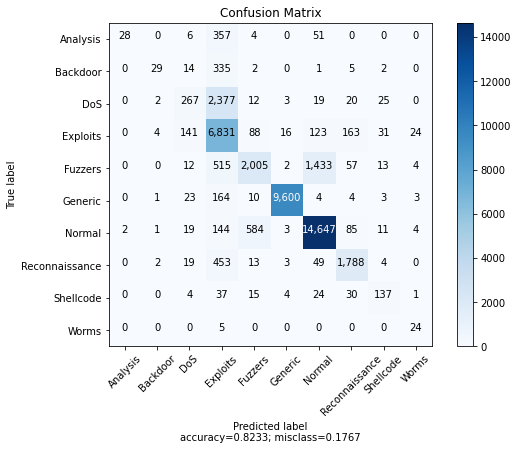

In [ ]:
cm = np.array(cm)
plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits',
                                      'Fuzzers','Generic','Normal', 'Reconnaissance',
                                      'Shellcode', 'Worms'],
                      title        = "Confusion Matrix")

In [ ]:
precision =[]
recall =[]
f1_score =[]
target_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits',
                                      'Fuzzers','Generic','Normal', 'Reconnaissance',
                                      'Shellcode', 'Worms']

for i in range(0,10):
  num_p = num_r = cm[i][i]
  sum_p = 0
  sum_r = 0
  for j in range(0,10):
    sum_p = sum_p + cm[i][j]
    sum_r = sum_r + cm[j][i]
  num_p = num_p/ sum_p
  num_r = num_r/ sum_r
  precision.append(num_p)
  recall.append(num_r)
  f1_score.append(2*num_p*num_r/ (num_p + num_r))

for i in range(0,10):
  print(target_names[i])
  print("Precision : ", precision[i])
  print("Recall : ", recall[i])
  print("F1-Score: ",  f1_score[i], "\n")

Analysis
Precision :  0.06278026905829596
Recall :  0.9333333333333333
F1-Score:  0.11764705882352942 

Backdoor
Precision :  0.07474226804123711
Recall :  0.7435897435897436
F1-Score:  0.1358313817330211 

DoS
Precision :  0.09798165137614678
Recall :  0.5287128712871287
F1-Score:  0.1653250773993808 

Exploits
Precision :  0.9204958900417733
Recall :  0.6089320734533785
F1-Score:  0.7329792370835345 

Fuzzers
Precision :  0.4961643157634249
Recall :  0.7336260519575558
F1-Score:  0.5919692943607913 

Generic
Precision :  0.9783938035059111
Recall :  0.9967812272868861
F1-Score:  0.9875019287147044 

Normal
Precision :  0.9449677419354838
Recall :  0.8957861904470674
F1-Score:  0.9197199459985558 

Reconnaissance
Precision :  0.767052767052767
Recall :  0.8308550185873605
F1-Score:  0.7976801249163505 

Shellcode
Precision :  0.5436507936507936
Recall :  0.6061946902654868
F1-Score:  0.5732217573221757 

Worms
Precision :  0.8275862068965517
Recall :  0.4
F1-Score:  0.5393258426966292

In [ ]:
# x axis values
x = [2,4,6,8,10]
# corresponding y axis values
y = [95,79,93,86,96]

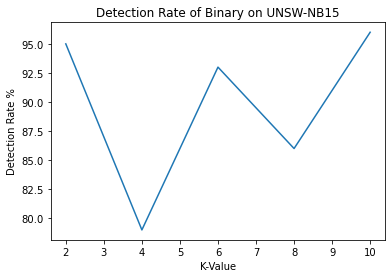

In [ ]:
# plotting the points
plt.plot(x, y)
plt.xlabel('K-Value')
plt.ylabel('Detection Rate %')
plt.title('Detection Rate of Binary on UNSW-NB15')
plt.show()